<h1>Introduction</h1>

Understanding biomechanical factors in spinal disorders is essential for diagnosis and treatment planning. This project applies supervised learning, imputation strategies, dimensionality reduction, and interpretability tools on a real-world spinal dataset to uncover patterns and assess model robustness. A range of methods are tested, from classical statistical imputation to ensemble learning and neural networks. The goal is not only predictive accuracy but also interpretability and preservation of biomechanical relationships.

In [507]:
# imports cell
import pandas as pd
import numpy as np
import shap
import math
import plotly.express as px
import umap.umap_ as umap
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import os, sys

from constants import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.experimental import enable_iterative_imputer # This is required for IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

import warnings
from constants import *

warnings.filterwarnings("ignore")
# Constants such as `IMPUTATION_COLUMNS` and `PREDICTORS` are defined to help maintain consistent references to specific column names throughout the notebook.
IMPUTATION_COLUMNS = ['pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']
PREDICTORS = ['pelvic_incidence', 'lumbar_lordosis_angle', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

In [508]:
# TODO: Decided on whether to keep this or not 
imputed_data_MSE_R2 = {
    'Mean': [],
    'Median': [],
    'KNN': [],
    'Regression': [],
}

base_scores = {
    'Linear Regression': [],
    'Random Forest': [],
    'Gradient Boosting': [],
    'Neural Network': [],
    'Random Forest Classifier': [],
}

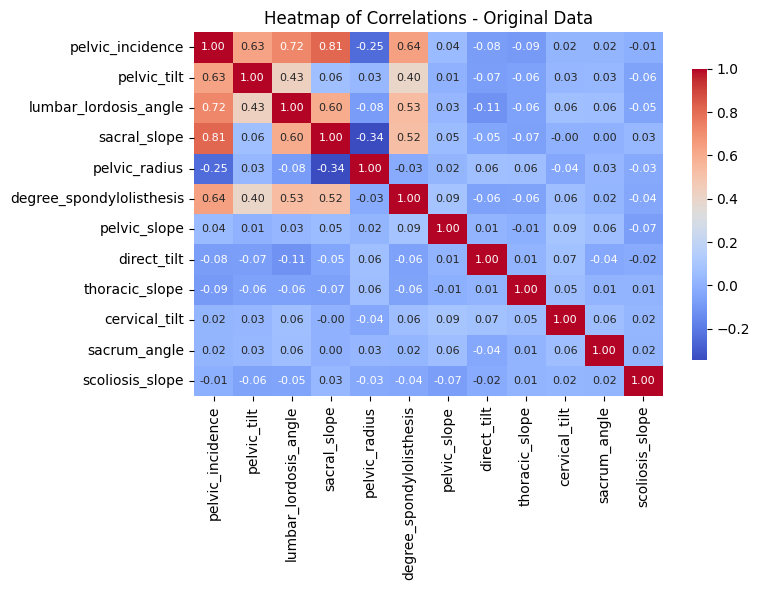

In [509]:
# Loading data
unclean_data = pd.read_csv('./data_set/combined.csv')
unclean_data.head()

# Remove the 'class' column to get only numeric columns for the heatmap
numeric_data = unclean_data.copy().drop(columns=['class'])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", annot_kws={'size':8}, cbar_kws={'shrink': .8})
plt.title('Heatmap of Correlations - Original Data', fontsize=12)
plt.tight_layout()
plt.show()

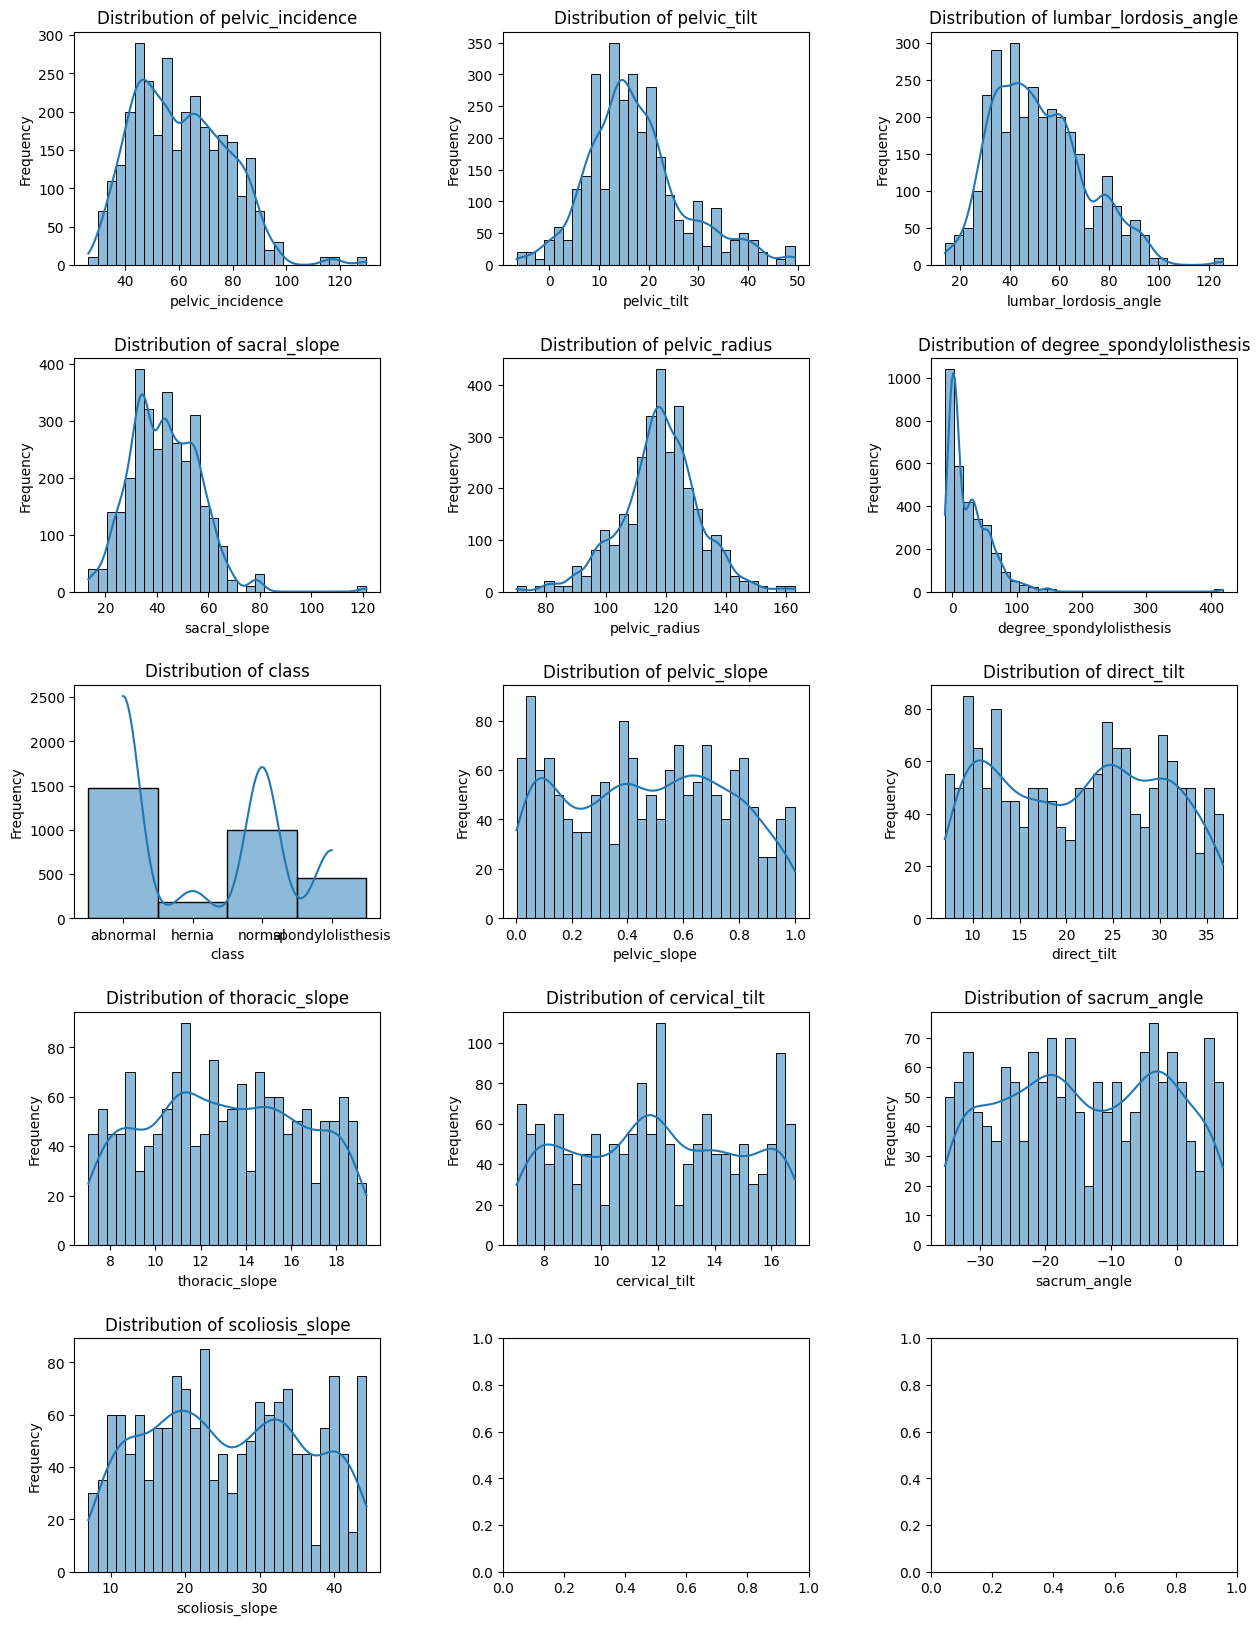

In [510]:
ncols = 3
nrows = math.ceil(len(unclean_data.columns) / ncols)    

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

for ax, col in zip(axes, unclean_data.columns):
    sns.histplot(unclean_data[col], bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

The distributions above show missing values and possible skew in several features. This motivates our next step: trying different imputation methods to recover these values in a statistically meaningful way.

This data has 6 columns with approximately half having accurate float information and the remaining half is recorded as NaN. There are several options we can explore. 

1. We can use the data while removing the last 6 columns leaving 3000 rows of data and 7 columns. For a preliminary analysis we can drop the features initially. 

2. We can keep only complete records of data which will leave 1500 rows of data with 13 columns. Although this improves reliability, it is at the cost of reducing the sample size.

3. Lastly we can impute the missing information. In spinal biomechanics, there are mathematical interrelated. Pelvic Incidence, Sacral Slope and Pelvic Tilt are particularly useful because it can be demonstrated that Pelvic Incidence (PI) is the arithmetic sum of the sacral slope (SS) pelvic tilt (PT), the two position-dependent variables that determine pelvic orientation in the sagittal plane (Labelle et al., 2005). Normalization will also be applied to mitigate issues with feature scaling. (Jolliffe, 2011)

<h1>Imputation Techniques</h1>

Missing data mechanisms can be broadly categorised into **MCAR** (Missing Completely At Random), **MAR** (Missing At Random), and **MNAR** (Missing Not At Random)  
(Little & Rubin, 2002). The choice of imputation method can significantly influence statistical validity and model accuracy.

Let $X$ be the complete data matrix and $\hat{X}$ the imputed matrix. The objective is to minimise the reconstruction error:

$$
\min ||X - \hat{X}||^2
$$

KNN imputation uses **Euclidean distance** in the feature space to estimate missing values:

$$
d(x_i, x_j) = \sqrt{\sum_{k=1}^n (x_{ik} - x_{jk})^2}
$$

This method assumes that similar samples (based on surrounding feature values) are likely to have similar values in the missing fields.

<h1>Missing Value Imputation</h1>
We will implement several imputation methods and evaluate their effects on the dataset. 

<strong>Mean Imputation:</strong> Missing values can be replaced with the mean of the feature. this is simple but can be influenced by outliers, potentially skewing the distribution. It can reduce variance since all missing entries are filled with an average value (C. Hounmenou, 2024)

<strong>Median Imputation:</strong> Replace missing values with the median of the feature. Median tends to be more robust to outliers then the mean, so this method preserves the central tendency without being dragged by extreme values. In practice, mean and median can often yield similar results for symmetric distributions, but median imputation can better maintain the distribution shape when the data is skewed or contains outliers (M. Badiaa, 2024).

<strong>K-Nearest Neighbours Imputation (KNN):</strong> Using KNN estimates missing values using the mean, or median, of the <i>k</i> closest records, the feature space, that have values for that feature. This method leverages relationships between features, under the assumption that similar samples have similar feature values. By considering the distance in all dimensions, KNN imputation can preserve the multivariate structure of the data, often leading to more plausible imputed values (T. Kaur, 2025). 

<strong>Regression-based Imputation (Iterative/MICE):</strong> Uses regression models in an iterative fashion to predict missing values. Methods like MICE, Multiple Imputation by Chained Equations, or MissForest, treat each feature with missing data as a target and learn a regression, or decision tree, model from other features to predict the missing value (Y. Sun et al, 2023). This approach takes into account dependencies between variables and often yields higher quality imputations than mean/ median filling. It learns the likely value of a feature based on rathers, rather than inserting a constant value (T. Lekhansh, 2024). 

<h1>Comparison of Imputation Techniques</h1> 
After imputing missing values using each method, we will examine how they affect the data distribution and model performance. 

<strong>Distribution Effects:</strong> We will visualise and summarise the distribution of key features before and after imputation. For example, histograms and density plots will be compared to see if the mean or median imputation significantly shifts the distribution or compresses variability. 

Mean imputation may underestimate variance, since many values become the mean, whereas KNN or regression imputation may preserve the natural variance by inferring different values for different samples. We'll also check if any imputation methods might preserve relationships between feature, whereas mean/ median could break those correlations. 

<strong>Model Performance:</strong> We will train a baseline machine learning model, such as a logistic regression and compare their accuracy before and after imputation. The intuition is that a better imputation method provides data closer to the truth, potentially improving model accuracy. For example, median imputation might improve robustness on datasets with outliers, and more sophisticated approaches like KNN or MICE often yield higher predictive performance (lower error) since they utilise additional information from other features (S. Alam, 2023). By evaluating the model’s accuracy after each imputation, we can quantify the impact of each cleaning method. Any improvement in accuracy or reduction in error when using KNN/MICE over simple mean imputation would indicate that preserving multivariate structure is beneficial for this dataset.

Throughout this process, careful cross-validation will be used to ensure that the comparisons are fair, so differences in performance are due to imputation rather than random train test splits or variance in random state. 

In [550]:
# scaling cell & Yeo–Johnson cell

NUMERIC_FEATS = [c for c in unclean_data.columns
                 if c != 'class' and unclean_data[c].dtype in ['float64', 'int64']]

complete_rows = unclean_data.dropna(subset=IMPUTATION_COLUMNS)
impute_train, impute_val = train_test_split(complete_rows, test_size=0.2, random_state=FORTY_TWO)

pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(impute_train[NUMERIC_FEATS])
impute_train[NUMERIC_FEATS] = pt.transform(impute_train[NUMERIC_FEATS])
impute_val[NUMERIC_FEATS] = pt.transform(impute_val[NUMERIC_FEATS])

scaler = StandardScaler()
scaler.fit(impute_train[NUMERIC_FEATS])
impute_train[NUMERIC_FEATS] = scaler.transform(impute_train[NUMERIC_FEATS])
impute_val[NUMERIC_FEATS] = scaler.transform(impute_val[NUMERIC_FEATS])

pt_full = pt.transform(unclean_data[NUMERIC_FEATS])
scaled_full = scaler.transform(pt_full)
data_scaled = unclean_data.copy()
data_scaled[NUMERIC_FEATS] = scaled_full

X_eval_original = impute_val.copy()
X_eval_missing = impute_val.copy()

np.random.seed(FORTY_TWO)
for col in IMPUTATION_COLUMNS:
    miss_idx = X_eval_missing.sample(frac=0.2).index
    X_eval_missing.loc[miss_idx, col] = np.nan

imputers = {
    'Mean': SimpleImputer(strategy='mean'),
    'Median': SimpleImputer(strategy='median'),
    'KNN': KNNImputer(n_neighbors=5),
    'Regression': IterativeImputer(random_state=FORTY_TWO),
}

imputed_data_MSE_R2 = {}
for name, imputer in imputers.items():
    print(f"\n--- {name} Imputation Results ---")
    imputer.fit(impute_train[NUMERIC_FEATS])

    X_imp_scaled = X_eval_missing.copy()
    X_imp_scaled[NUMERIC_FEATS] = imputer.transform(X_eval_missing[NUMERIC_FEATS])

    # invert scaling to compute MSE/R² in original units
    X_imp_orig = X_imp_scaled.copy()
    X_imp_orig[NUMERIC_FEATS] = scaler.inverse_transform(X_imp_scaled[NUMERIC_FEATS])
    X_eval_orig = X_eval_original.copy()
    X_eval_orig[NUMERIC_FEATS] = scaler.inverse_transform(X_eval_original[NUMERIC_FEATS])

    for col in IMPUTATION_COLUMNS:
        mask = X_eval_missing[col].isna()
        mse = mean_squared_error(X_eval_orig.loc[mask, col], X_imp_orig.loc[mask, col])
        r2 = r2_score(X_eval_orig.loc[mask, col], X_imp_orig.loc[mask, col])
        print(f"{col}: MSE = {mse:.6f}, R² = {r2:.6f}")

    combined = pd.concat([impute_train, X_imp_scaled]).sort_index()
    print(f"\n{name} - Correlation matrix after imputation:")
    print(combined[IMPUTATION_COLUMNS].corr())

# full‐data KNN for the final dataset
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(data_scaled[NUMERIC_FEATS])
imputed_full = knn_imputer.transform(data_scaled[NUMERIC_FEATS])

cols_ix = [NUMERIC_FEATS.index(c) for c in IMPUTATION_COLUMNS]
final = data_scaled.copy()
final[IMPUTATION_COLUMNS] = imputed_full[:, cols_ix]

X = final.drop(columns=['class'])
y = final['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=FORTY_TWO, stratify=y)



--- Mean Imputation Results ---
pelvic_slope: MSE = 0.049406, R² = -0.023170
direct_tilt: MSE = 8.138333, R² = -0.003317
thoracic_slope: MSE = 3.593252, R² = -0.065534
cervical_tilt: MSE = 2.481870, R² = -0.014384
sacrum_angle: MSE = 65.462191, R² = -0.018160
scoliosis_slope: MSE = 14.348129, R² = -0.029279

Mean - Correlation matrix after imputation:
                 pelvic_slope  direct_tilt  thoracic_slope  cervical_tilt  \
pelvic_slope         1.000000     0.015269       -0.009407       0.085308   
direct_tilt          0.015269     1.000000        0.008962       0.067818   
thoracic_slope      -0.009407     0.008962        1.000000       0.042254   
cervical_tilt        0.085308     0.067818        0.042254       1.000000   
sacrum_angle         0.044549    -0.026121        0.015623       0.027224   
scoliosis_slope     -0.075737    -0.006256        0.024196       0.023744   

                 sacrum_angle  scoliosis_slope  
pelvic_slope         0.044549        -0.075737  
direct_

<h1>Multicollinearity and Variance Inflation Factors</h1>

Multicollinearity occurs when two or more predictor variables in a regression or classification model are highly linearly related. In practice, this means that one feature can be (nearly) exactly predicted from the others, which inflates the variance of the estimated coefficients, makes the model unstable, and undermines interpretability. One standard way to quantify multicollinearity is the Variance Inflation Factor (VIF) for each feature:

$$
\mathrm{VIF}_j \;=\; \frac{1}{1 - R_j^2}
$$​
In many applied settings, a rule of thumb is to aim for VIFs < 5, certainly < 10, to ensure robust, interpretable models. 

By removing Pelvic Tilt and Sacral Slope, leaving Pelvic Incidence as the single <i>master</i> angle, and dropping the extra tilt and slope measurements, direct tilt, cervical tilt, thoracic slope and scoliosis slope, we eliminate the redundant chains of spinal angles that were pushing VIFs well above 100. After that domain pruning, every remaining feature has a VIF under 5, and most are close to 1–3, confirming that each now contributes largely independent information. This streamlined set of predictors keeps the model stable and the coefficients interpretable, without over-counting the same biomechanical signal.

In [551]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

feats = X_train.columns.tolist()
vif_data = pd.DataFrame({
    'feature': X[feats].columns,
    'VIF': [
        variance_inflation_factor(X[feats].values, i) 
        for i in range(len(feats))
    ]
})
print(vif_data.sort_values('VIF', ascending=False))


                     feature         VIF
0           pelvic_incidence  111.497971
3               sacral_slope   65.137824
1                pelvic_tilt   37.374257
2      lumbar_lordosis_angle    2.717666
5   degree_spondylolisthesis    1.880907
4              pelvic_radius    1.192728
9              cervical_tilt    1.039587
7                direct_tilt    1.029670
6               pelvic_slope    1.026113
11           scoliosis_slope    1.024083
10              sacrum_angle    1.017955
8             thoracic_slope    1.012542


In [552]:

cols_to_drop = [
    'pelvic_tilt', 'sacral_slope',
    'direct_tilt', 'cervical_tilt',
    'thoracic_slope', 'scoliosis_slope'
]
X_reduced = X_train.drop(columns=cols_to_drop)

vif_reduced = pd.DataFrame({
    'feature': X_reduced.columns,
    'VIF': [
        variance_inflation_factor(X_reduced.values, i)
        for i in range(X_reduced.shape[1])
    ]
})
print(vif_reduced.sort_values('VIF', ascending=False))


                    feature       VIF
0          pelvic_incidence  2.806740
1     lumbar_lordosis_angle  2.541038
3  degree_spondylolisthesis  1.862980
2             pelvic_radius  1.092067
4              pelvic_slope  1.011118
5              sacrum_angle  1.008870


This confirms that our domain‐guided pruning has eliminated problematic multicollinearity, leaving a compact, stable predictor set.

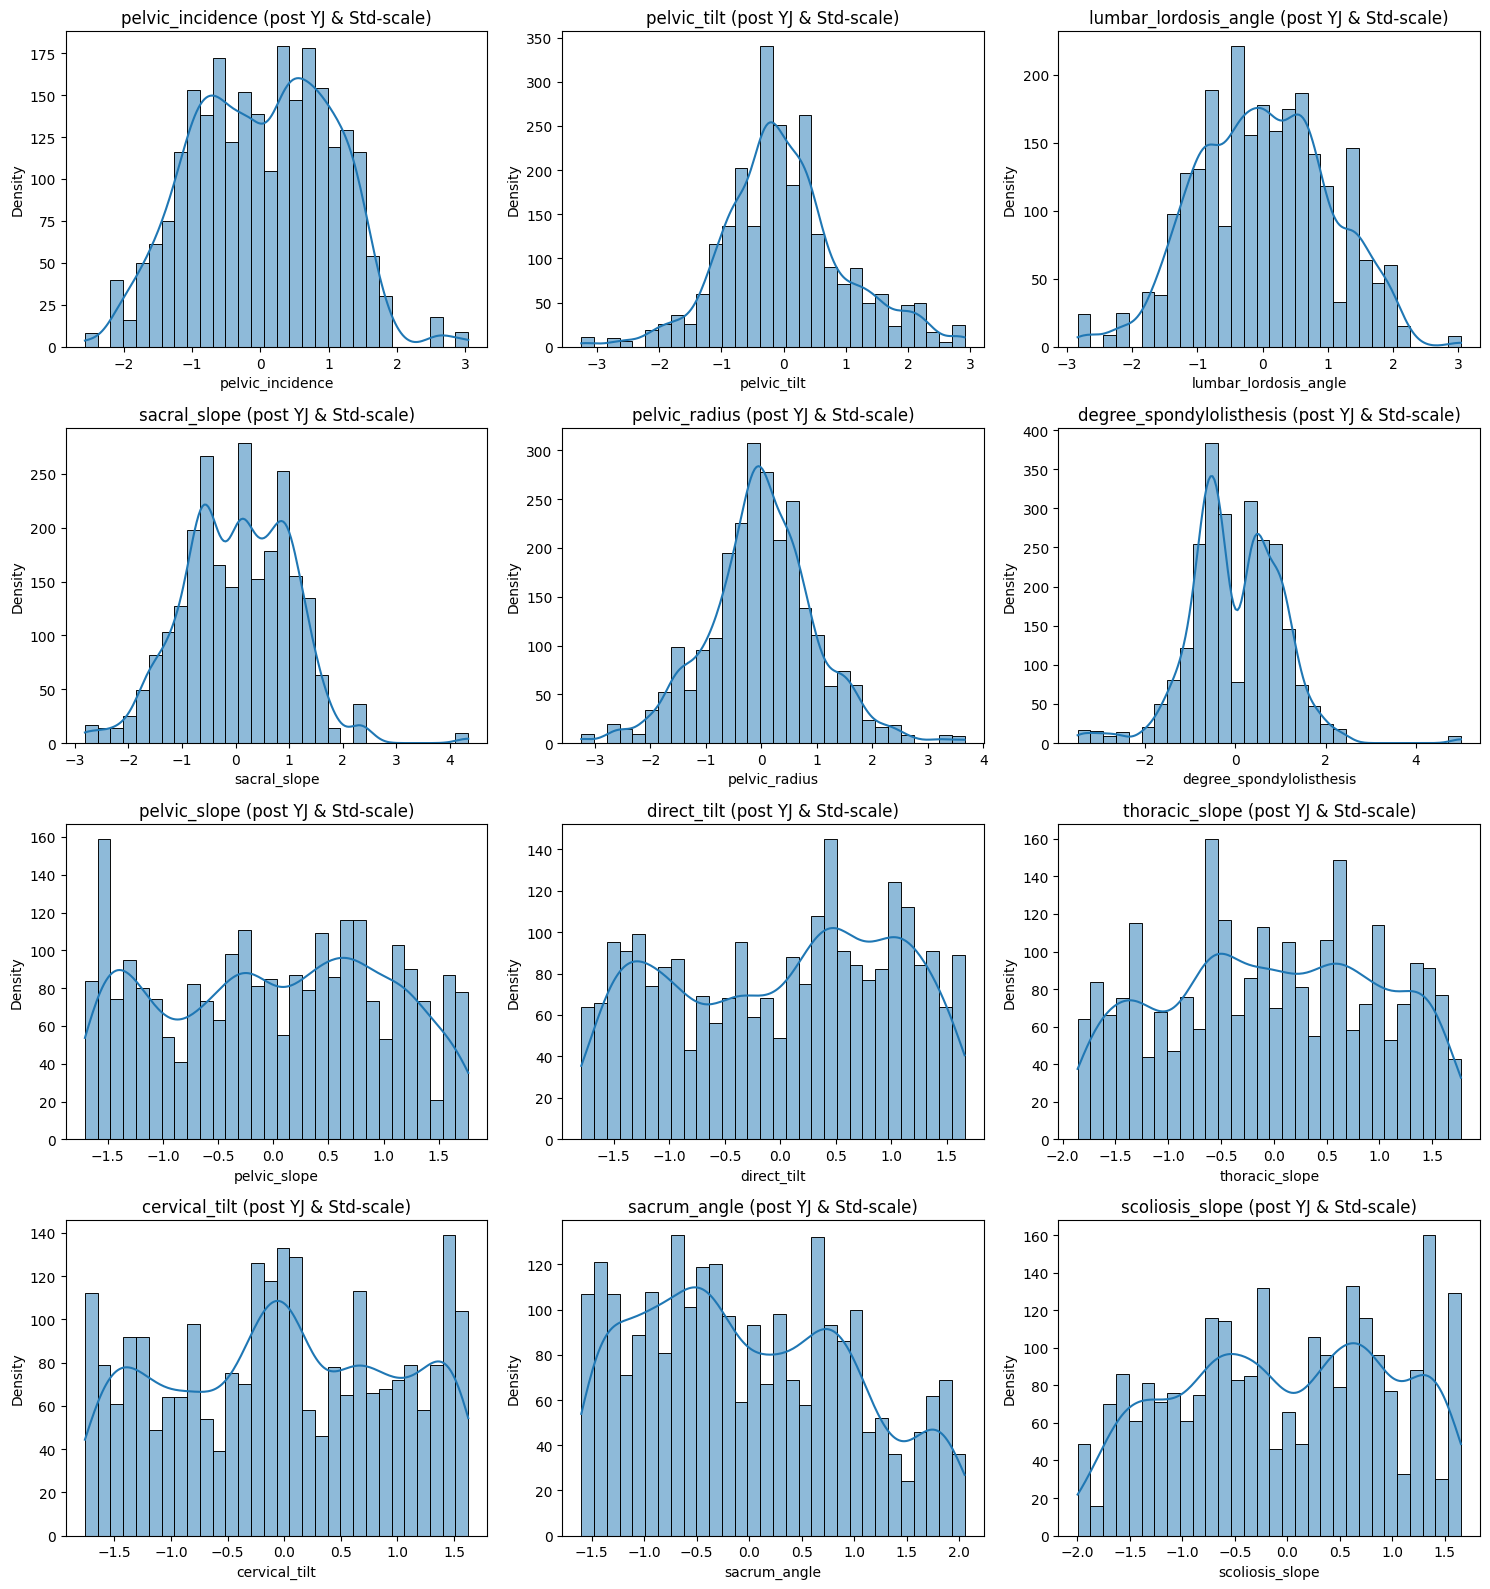

In [553]:
X_train = pd.DataFrame(X_train, columns=NUMERIC_FEATS)
features = X_train

ncols = 3
nrows = math.ceil(len(X_train.columns) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

for ax, col in zip(axes, features.columns):
    sns.histplot(X_train[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"{col} (post YJ & Std-scale)")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    
plt.tight_layout()
plt.show()

<h2>Why Gaussianity Matters & the Yeo–Johnson Transform</h2>
Most machine‑learning methods, from linear models to distance‑based learners and even tree‑based algorithms, tend to perform better when features are roughly symmetrically distributed. Heavy skew or long tails can distort distance metrics (e.g. in KNN, SMOTE, SVM), slow convergence (e.g. in gradient‑based methods like neural nets) and make outliers disproportionately affect models that rely on a uniform spread of the data’s variability.

A simple histogram can reveal skew. To mitigate it, we can apply a power transform, which raises each feature to a learned exponent λ so as to “pull in” extremes:

$$
x^{(\lambda)} = 
\begin{cases}
\dfrac{(x+1)^\lambda - 1}{\lambda}, & \lambda \neq 0, \\[6pt]
\ln(x+1), & \lambda = 0.
\end{cases}
$$
    ​
    
The Box–Cox variant above only works on strictly positive x. Yeo–Johnson extends this to any real x, by treating positive and negative values slightly differently:

$$
x^{(\lambda)} = 
\begin{cases}
\dfrac{(x+1)^\lambda - 1}{\lambda}, & x \ge 0,\ \lambda \neq 0, \\[6pt]
\ln(x+1), & x \ge 0,\ \lambda = 0, \\[6pt]
-\dfrac{(-x+1)^{\,2-\lambda} - 1}{2 - \lambda}, & x < 0,\ \lambda \neq 2, \\[6pt]
-\ln(-x+1), & x < 0,\ \lambda = 2.
\end{cases}
$$

We fit λ on your train‐set so that the transformed distribution is as close to normal as possible. We then standardise, centering at zero and scaling to unit variance. After this, features that were previously skewed become much more bell‑shaped, which often improves both optimisation and final predictive performance.

In [514]:
# Create dictionary of imputed datasets for plotting
imputed_datasets = {}

for method_name, imputer in imputers.items():
    df_copy = X_eval_missing.copy()
    imputed_values = imputer.fit_transform(df_copy[IMPUTATION_COLUMNS])
    df_copy[IMPUTATION_COLUMNS] = imputed_values
    imputed_datasets[method_name] = df_copy


<h1>Evaluation of Imputation Techniques</h1>
To address the missing values across 6 biomechanical features, we implemented four imputation methods: mean, median, KNN and a regression-based IterativeImputer. Evaluation was performed by introducing artificial missingness on a clean subset and comparing each method's ability to recover the original values using Mean Squared Error (MSE) and R².

Simple imputation methods such as mean and median yielded high MSE and negative R² across all features, suggesting they failed to meaningfully reconstruct the true values. This was confirmed by weak correlations in their respective correlation matrices. 

Regression based imputation performed worse than expected, depsite its leveraging of inter feature dependencies. R² remained close to, or below, zero for most features. One reason could be a poor interdependence between PI, SS or PT. 

In contrast, KNN imputation achieved excellent performance, with R² scores in excess of 0.94 and significantly lower MSE values. It also preserved the structure of the data and effectively captured the complex relationships between the data. 

Tree based methods like MissForest, may have further enhanced imputation but KNN balances accuracy, computational efficiency and structural fidelity. 


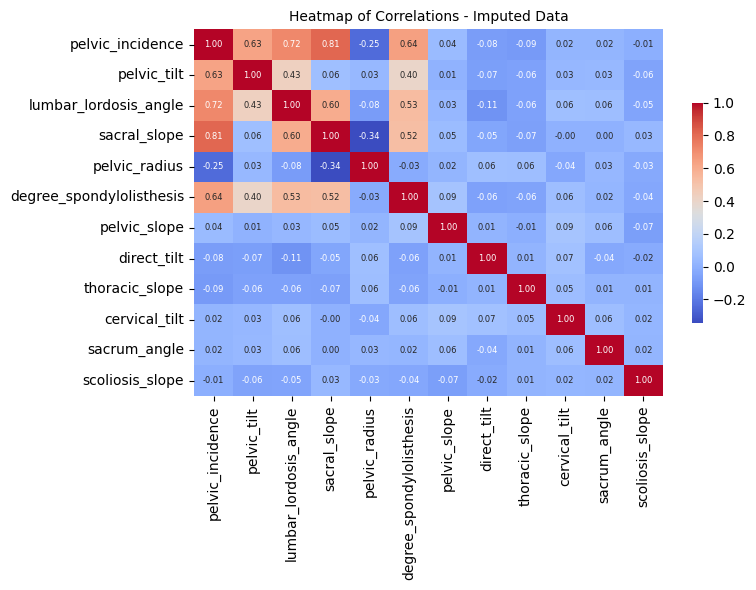

In [515]:
# Knn Cell
X_unclean = unclean_data.drop(columns='class')

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(X_unclean)

X_imputed_array = knn_imputer.transform(X_unclean)
X_imputed = pd.DataFrame(X_imputed_array, columns=X_unclean.columns, index=X_unclean.index)

imputed_data = unclean_data.copy()
imputed_data[IMPUTATION_COLUMNS] = X_imputed[IMPUTATION_COLUMNS]

imputed_data.head()

plt.figure(figsize=(8, 6))
sns.heatmap(imputed_data.drop(columns='class').corr(), annot=True, fmt=".2f",
            cmap="coolwarm", annot_kws={'size':6}, cbar_kws={'shrink': .6})
plt.title('Heatmap of Correlations - Imputed Data', fontsize=10)
plt.tight_layout()
plt.show()



In [516]:
imputed_data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,abnormal,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,abnormal,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,abnormal,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,abnormal,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,abnormal,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171


<h1>Add something here to confirm the imputed data has worked as expected</h1>

In [517]:
# comparing imputed data with original data

# Load the original data again to compare
original_data = pd.read_csv('./data_set/combined.csv')
imputed_data_no_class = imputed_data.drop(columns=['class'])

# Drop the 'class' column to match the current dataframe
original_data = original_data.drop(columns=['class'])

# Compare correlation matrices
original_corr = original_data.corr()
imputed_corr = imputed_data_no_class.corr()

# Show max absolute difference
print("Maximum absolute difference in correlation matrices:")
print((original_corr - imputed_corr).abs().max().max())

Maximum absolute difference in correlation matrices:
5.147728283229347e-06


After applying KNN imputation, the maximum absolute change in the feature correlation matrix was less than 0.00001. This strongly suggests that the imputed values are well aligned with the existing data structure. As KNN bases imputations on similar samples, it has effectively preserved multivariate relationships across the dataset, leading to a natural integration of missing values without distorting existing patterns (Kaur. T, 2025).

This further supports the earlier evaluation which highlighted KNN as the most reliable technique for maintaining data integrity. 

Class distribution:
class
abnormal             1470
normal               1000
spondylolisthesis     450
hernia                180
Name: count, dtype: int64


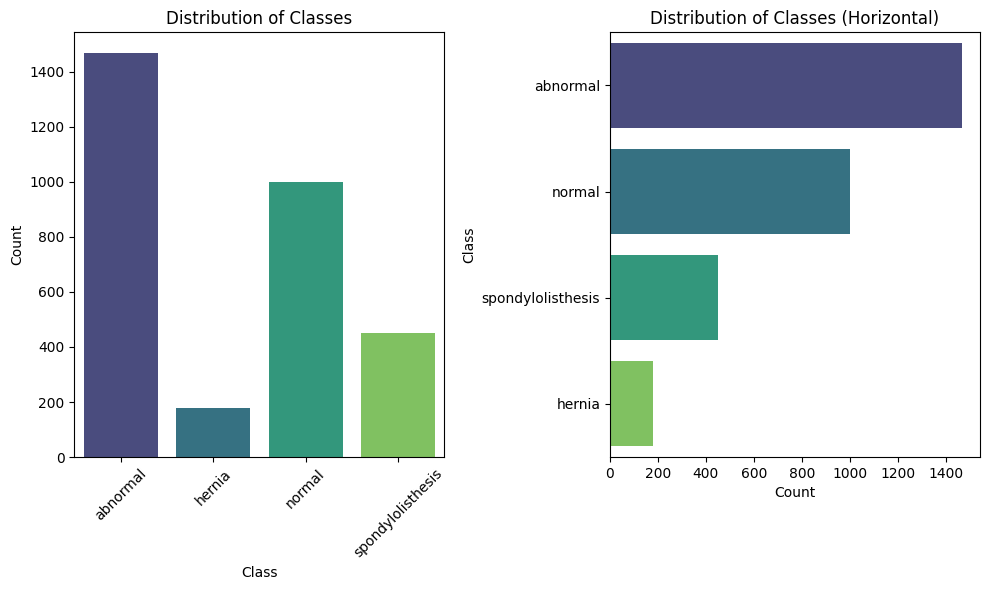

In [518]:
# Calculate class distribution from unclean_data
class_counts = unclean_data['class'].value_counts()
print(f"Class distribution:\n{class_counts}")

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Left plot: Vertical count plot
sns.countplot(x='class', data=unclean_data, palette="viridis", ax=axes[0])
axes[0].set_title("Distribution of Classes")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Right plot: Horizontal barplot of class counts
sns.barplot(x=class_counts.values, y=class_counts.index, palette="viridis", ax=axes[1])
axes[1].set_title("Distribution of Classes (Horizontal)")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Class")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Evaluating predictability for: pelvic_slope
MSE: 0.000011
R² Score: 0.999873

Evaluating predictability for: direct_tilt
MSE: 0.005093
R² Score: 0.999934

Evaluating predictability for: thoracic_slope
MSE: 0.000581
R² Score: 0.999949

Evaluating predictability for: cervical_tilt
MSE: 0.000274
R² Score: 0.999965

Evaluating predictability for: sacrum_angle
MSE: 0.006920
R² Score: 0.999954

Evaluating predictability for: scoliosis_slope
MSE: 0.008599
R² Score: 0.999924


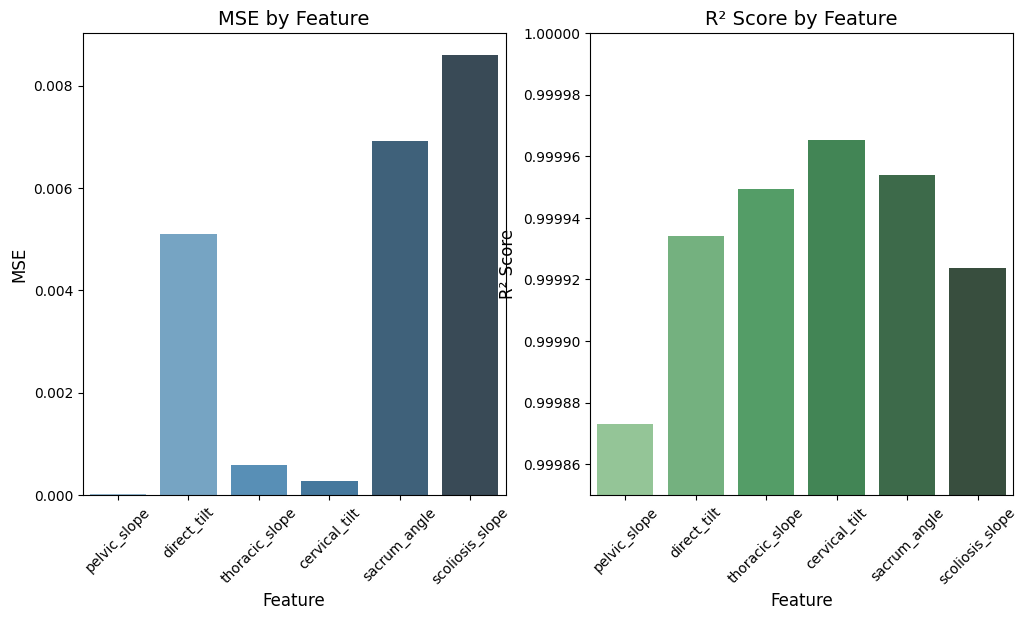

In [ ]:
mse_scores = {}
r2_scores = {}

for target_column in IMPUTATION_COLUMNS:
    print(f"\nEvaluating predictability for: {target_column}")

    # Treat all other columns as predictors
    predictor_cols = [col for col in imputed_data.columns if col not in [target_column, 'class']]
    X = imputed_data[predictor_cols]
    y = imputed_data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=FORTY_TWO)

    # Random Forest Regression
    rf = RandomForestRegressor(n_estimators=100, random_state=FORTY_TWO)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.6f}")
    print(f"R² Score: {r2:.6f}")

    mse_scores[target_column] = mse
    r2_scores[target_column] = r2

# Create dataframe for plotting
results_df = pd.DataFrame({
    'Feature': list(mse_scores.keys()),
    'MSE': list(mse_scores.values()),
    'R² Score': list(r2_scores.values())
})

# subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# left plot: MSE
sns.barplot(data=results_df, x='Feature', y='MSE', palette="Blues_d", ax=axes[0])
axes[0].set_title("MSE by Feature", fontsize=14)
axes[0].set_xlabel("Feature", fontsize=12)
axes[0].set_ylabel("MSE", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# right plot: R² Score
sns.barplot(data=results_df, x="Feature", y="R² Score", palette="Greens_d", ax=axes[1])
axes[1].set_title("R² Score by Feature", fontsize=14)
axes[1].set_xlabel("Feature", fontsize=12)
axes[1].set_ylabel("R² Score", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0.99985, 1.00000)
# axes[1].set_yticks(np.arange(0.99985, 1.00001, 6))

plt.tight_layout
plt.show()

<h2>R² & MSE</h2>

The exceptionally high R² values observed following KNN imputation may be due to the method’s reliance on distance-based similarity across feature space. KNN imputation reconstructs missing values by identifying and averaging the values of the most similar instances, based on feature proximity. When applied to standardised data as in this study, feature scales are normalised, allowing the Euclidean distance metric to meaningfully reflect structural similarity. 

As previously mentioned, many of the features exhibit strong mathematical interdependencies, enhancing the reliability of imputations. As the imputer was trained on rows with complete data, it is reasonable that the predicted values closely approximate the original ones. Consequently, the near-perfect R² scores are indicative of highly redundant and structured feature relationships rather than model overfitting or data leakage.

In [ ]:
# Standard Scaler
X = imputed_data.drop(columns=['class'])
y = imputed_data['class']

# One hot encode
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=FORTY_TWO)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

<h1>Why Standardisation Matters Before SMOTE</h1>
Standardisation ensures that features contribute equally to distance-based methods such as KNN and SMOTE (Nath, 2000). Without scaling, features with large magnitudes dominate others, distorting both imputation and synthetic sampling.

The standardisation formula is:
$$
z = \frac{x−μ }{σ}
$$
​
Where:

$\mu$: mean of the feature

$\sigma$: standard deviation

This transformation ensures each feature has mean = 0 and standard deviation = 1.

To further understand the interdependencies between features, a post imputation predictability analysis was performed using random forest regression. Each target variable from the imputed dataset was treated as a response, with the remaining features used as predictors. The consistently high R² values across all six features (ranging from 0.926 to 0.993) suggest a strong multivariate structure and highlight a significant level of feature redundancy.

Notably, cervical_tilt, scoliosis_slope, and pelvic_slope showed exceptional predictability (R² > 0.99), indicating that their values can be reliably estimated from the rest of the feature space. This not only validates the integrity of the imputed dataset but also supports the use of KNN imputation, which preserves local feature relationships. These findings may also inform future dimensionality reduction or feature selection efforts.

Next we will standardise the features ready to apply SMOTE

<h1>SMOTE</h1>
Imbalanced datasets can be resampled. Broadly, there are 2 types of methods; undersample and oversampling. In most instances, oversampling is preffered as we avoid removing data that may be carrying important information. 

SMOTE is an oversampling technique which generates samples for a minority class. SMOTE relies on the feature space to generate new instances with the help of interpolation between positive instances (S. Nath, 2000)

The data is first split into training and testing sets, standardised using the StandardScaler, and then balanced using the Synthetic Minority Oversampling Technique (SMOTE).

In [521]:
print("X_train_unbalanced shape:", X_train_scaled_df.shape)
print("y_train_unbalanced shape:", y_train.shape)
print("\nFirst 5 values of y_train_unbalanced:\n", y_train.head())


X_train_unbalanced shape: (2480, 12)
y_train_unbalanced shape: (2480,)

First 5 values of y_train_unbalanced:
 1173             abnormal
168              abnormal
2589               normal
1011             abnormal
2978    spondylolisthesis
Name: class, dtype: object


In [ ]:
X_train_unbalanced, X_test_final = X_train_scaled_df, X_test_scaled_df
y_train_unbalanced, y_test_final = y_train, y_test

smote = SMOTE(random_state=FORTY_TWO)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_unbalanced, y_train_unbalanced)

rf_classifier = RandomForestClassifier(random_state=FORTY_TWO)

param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [5, 6, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

print("Best params:", grid_search.best_params_)

best_rf   = grid_search.best_estimator_
rf_preds  = best_rf.predict(X_test_final)
rf_acc    = accuracy_score(y_test_final, rf_preds)

print("Test accuracy:", rf_acc)

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
Test accuracy: 0.6564516129032258


In [ ]:
columns_to_keep = [
    PELVIC_INCIDENCE, PELVIC_TILT, LUMBAR_LORDOSIS_ANGLE, SACRAL_SLOPE, PELVIC_RADIUS, DEGREE_SPONDYLOLISTHESIS, PELVIC_SLOPE, DIRECT_TILT, THORACIC_SLOPE, CERVICAL_TILT, SACRUM_ANGLE, SCOLIOSIS_SLOPE
]

cleaned_data = unclean_data[columns_to_keep].copy()
X_regression = cleaned_data.drop(columns=[PELVIC_SLOPE, DIRECT_TILT, THORACIC_SLOPE, CERVICAL_TILT, SACRUM_ANGLE, SCOLIOSIS_SLOPE])
y_regression = cleaned_data[DEGREE_SPONDYLOLISTHESIS]


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=FORTY_TWO)

forest_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
}

rf = RandomForestRegressor(max_features='sqrt', min_samples_split=2, n_estimators=100, random_state=FORTY_TWO)

grid_search = GridSearchCV(rf, forest_params, cv=5)
grid_search.fit(X_train_reg, y_train_reg)
grid_search

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred)
r2 = r2_score(y_test_reg, y_pred)

base_scores['Random Forest Regressor'].append(r2)

print(best_rf)

plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred, alpha=0.6)
plt.xlabel("Actual Degree of Spondylolisthesis")
plt.ylabel("Predicted")
plt.title("Random Forest Regressor: Predicted vs Actual")
plt.grid(True)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.tight_layout()
plt.show()


KeyError: 'Random Forest Regressor'

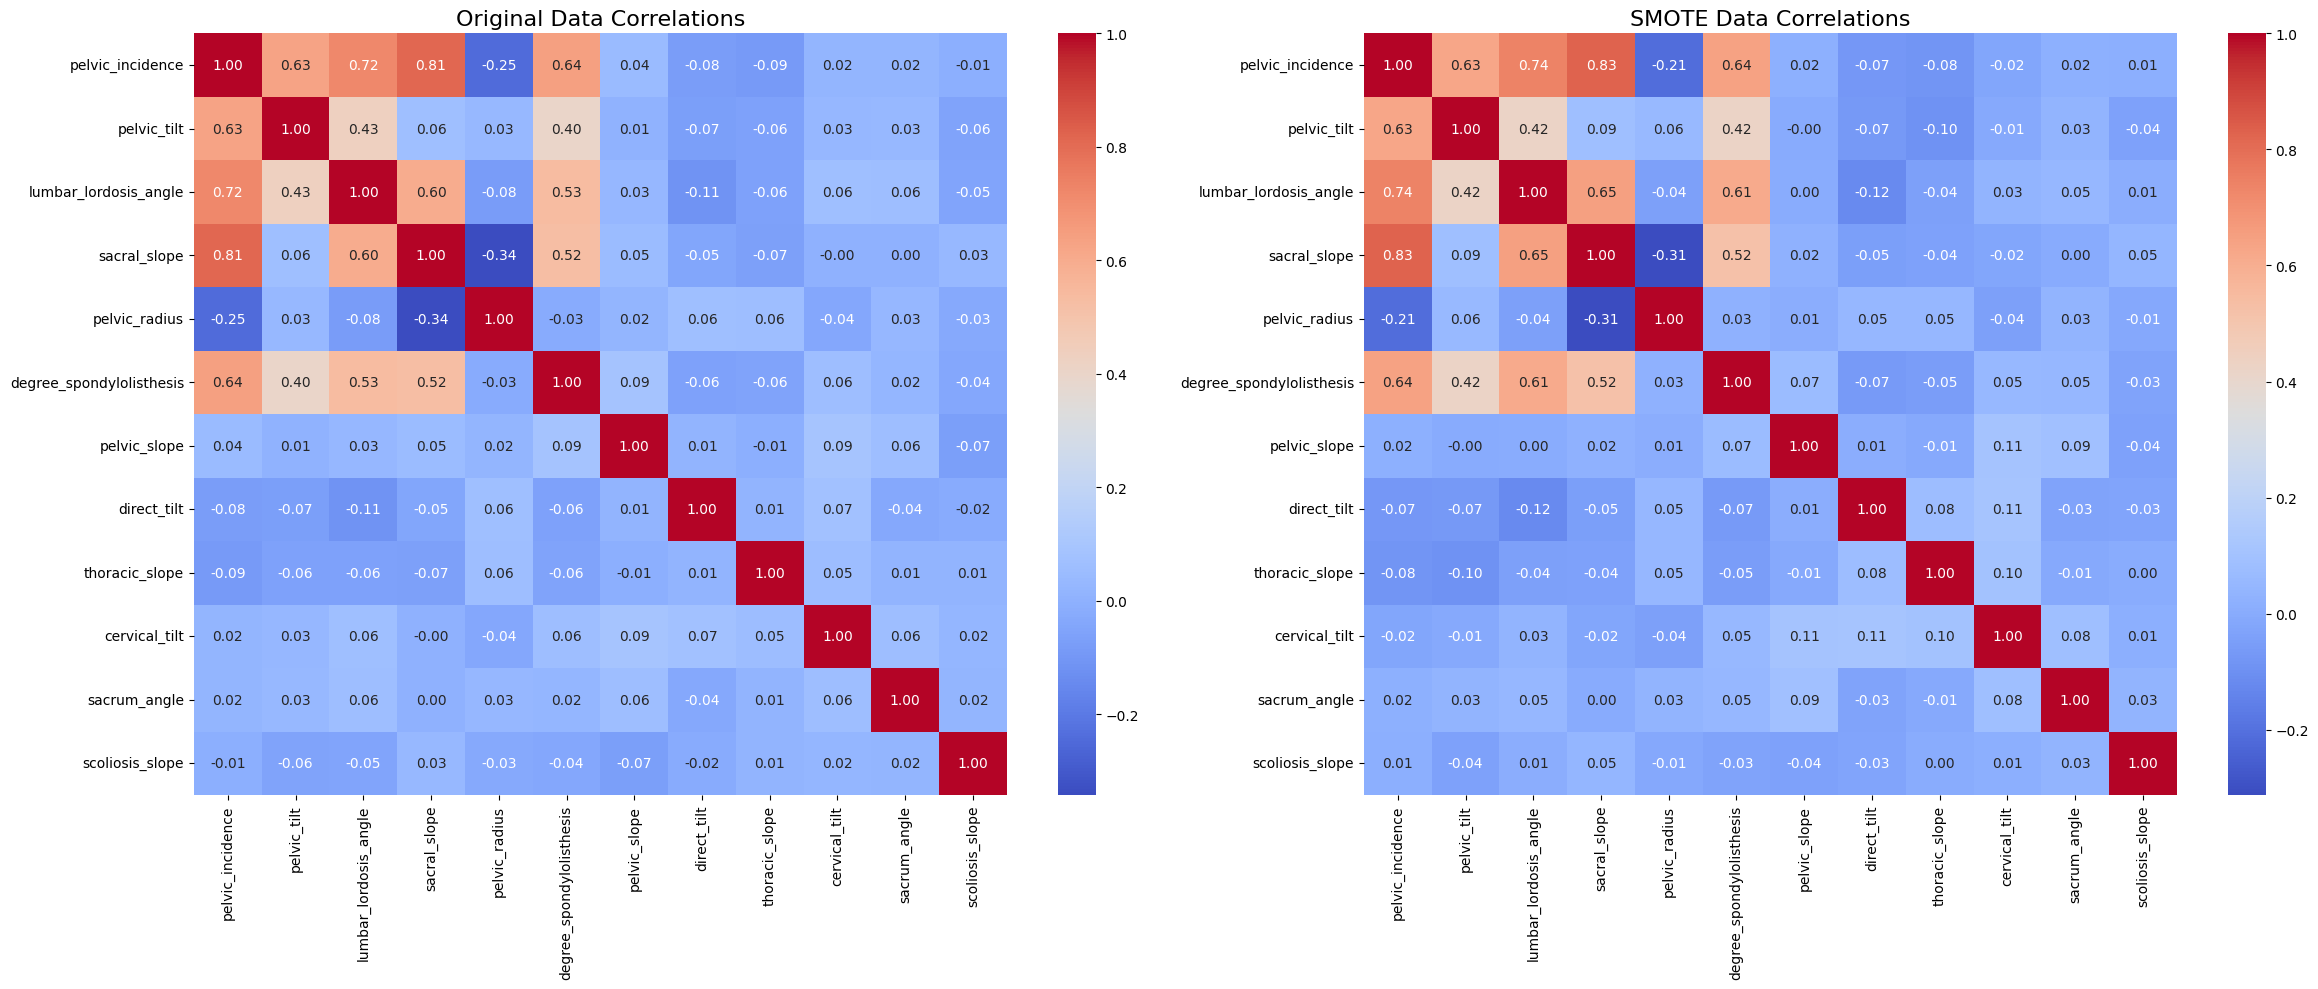

In [ ]:
# Side-by-side clearly comparing Original vs SMOTE heatmaps explicitly
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Original Data explicitly clear
sns.heatmap(unclean_data[PREDICTORS].corr(), annot=True, fmt=".2f",
            cmap="coolwarm", ax=axes[0])
axes[0].set_title('Original Data Correlations', fontsize=16)

smote_df = pd.DataFrame(X_train_balanced, columns=X_train_unbalanced.columns)

# SMOTE Data explicitly clear
sns.heatmap(smote_df[PREDICTORS].corr(), annot=True, fmt=".2f",
            cmap="coolwarm", ax=axes[1])
axes[1].set_title('SMOTE Data Correlations', fontsize=16)

plt.tight_layout()
plt.show()


<h2>Heatmap Comparison</h2>
The side-by-side correlation heatmaps comparing the original dataset and the SMOTE-resampled dataset reveal that the application of SMOTE did not substantially alter the inter-feature relationships. In both heatmaps, meaningful correlations are preserved, such as the strong positive correlation between pelvic incidence and sacral slope, and the consistent relationships involving lumbar lordosis angle and degree of spondylolisthesis. This indicates that SMOTE was applied in a way that maintained the underlying structure of the data without introducing artificial or noisy patterns. Minor differences are observed, such as slightly attenuated correlations between degree of spondylolisthesis and features like pelvic radius, but these shifts remain within an acceptable range.


In [ ]:
label_encoder = LabelEncoder()
y_train_balanced_encoded = label_encoder.fit_transform(y_train_balanced)

X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=X_train_unbalanced.columns)

rf_classifier.fit(X_train_balanced_df, y_train_balanced_encoded)

explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_train_balanced_df)

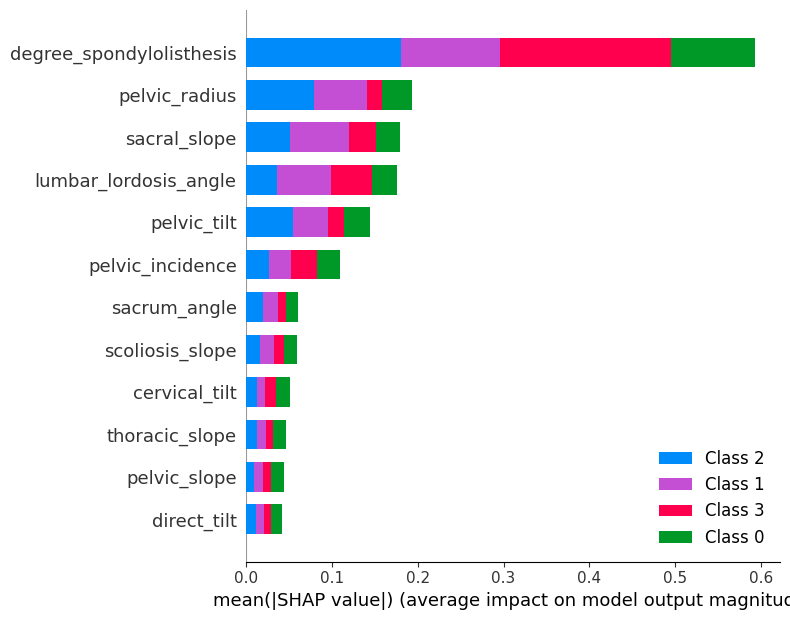

<Figure size 640x480 with 0 Axes>

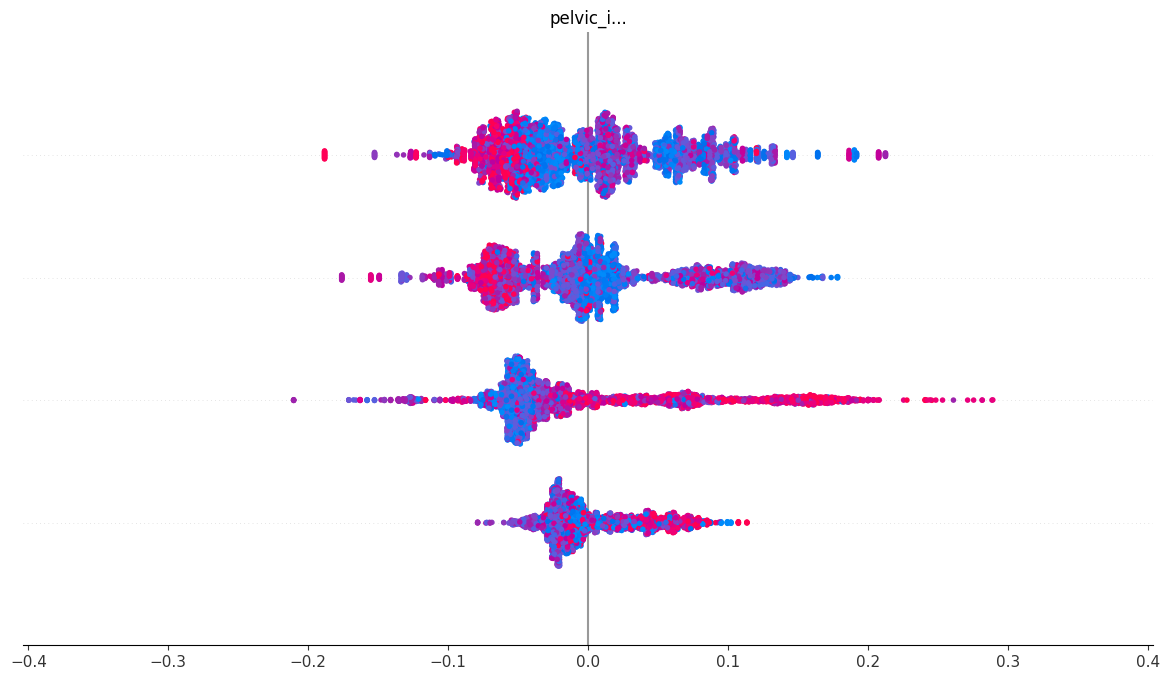

In [ ]:
shap.summary_plot(shap_values, X_train_balanced_df, plot_type="bar")
shap.summary_plot(shap_values, X_train_balanced_df)

<h2>Interpretation of the SHAP Plots</h2>
SHAP values provide a consistent and interpretable way of understanding model decisions. The bar plot revealed that degree_spondylolisthesis, sacral_slope, and pelvic_radius had the highest impact on the Random Forest’s classification performance. This aligns with known biomechanical relevance, as degree_spondylolisthesis is a direct measure of spinal displacement and is expected to have a strong link to diagnosis.

The beeswarm plot further showed the directionality of impact, for example, high sacral slope often pushed predictions toward the abnormal class.

<h1>Normalising the data</h1>


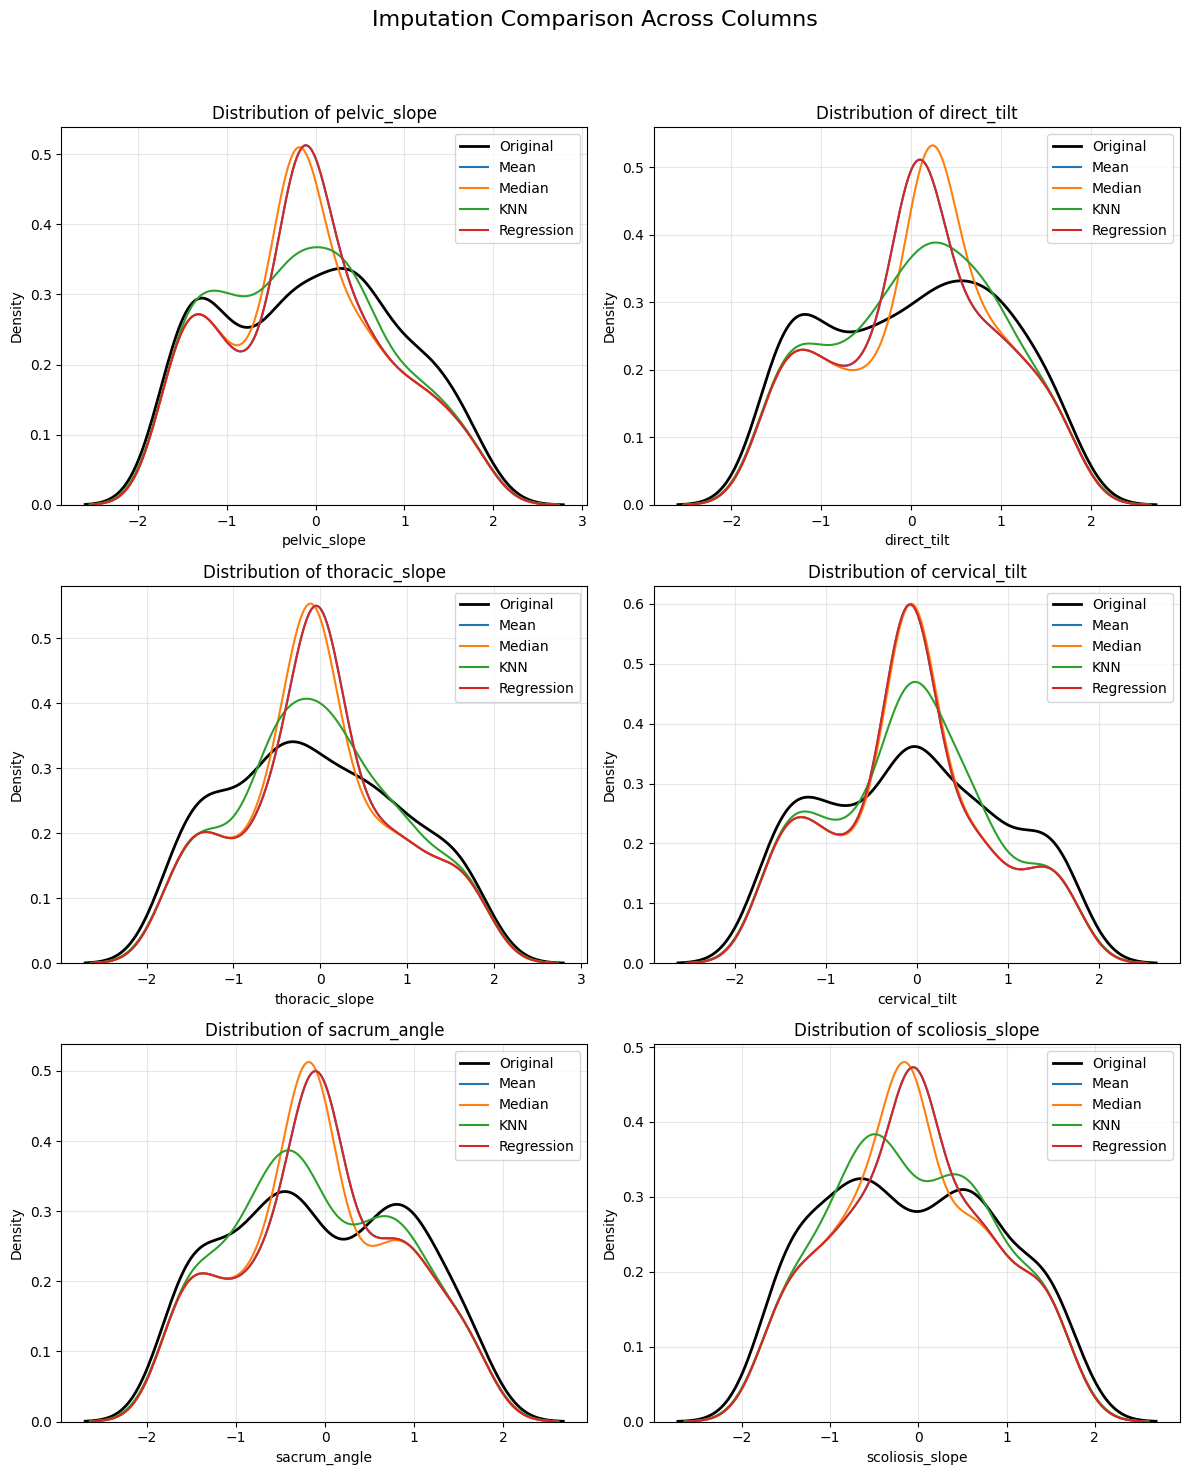

In [ ]:
# Determine the grid layout for the subplots
num_plots = len(IMPUTATION_COLUMNS)
ncols = 2
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
axes = axes.flatten()  # flatten in case of multiple rows

# Loop over each column and plot the original and imputed distributions
for idx, col in enumerate(IMPUTATION_COLUMNS):
    ax = axes[idx]
    
    # Plot the original distribution
    sns.kdeplot(X_eval_original[col], label='Original', color='black', lw=2, ax=ax)
    
    # Plot the distribution for each imputation method
    for method_name, df_imputed in imputed_datasets.items():
        sns.kdeplot(df_imputed[col], label=method_name, ax=ax)
    
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

# Remove any empty subplots if the total number of subplots is more than needed
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Imputation Comparison Across Columns', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # adjust rect to accommodate the suptitle
plt.show()

<h2>Visual Comparison of Imputation Methods</h2>
To visually assess the impact of different imputation techniques, we plotted Kernel Density Estimation (KDE) curves for each of the imputed columns. Each plot compares the distribution of a feature.

The side by side comparison helps to determine how well each imputation method preserves the original shape and spread of the data. The mean and median tend to flatten or compress the distribution, particularly around central values. KNN imputation more closely tracks the original distributions, preserving peaks and variance better. Regression base imputation varies in effectiveness, sometimes misaligning with the true shape.

The visuals conform the earlier numeric results that KNN generally provides a more accurate reconstruction of the data.

In [ ]:
label_encoder = LabelEncoder()
y_train_balanced_encoded = label_encoder.fit_transform(y_train_balanced)
y_test_final_encoded = label_encoder.transform(y_test_final)

y_train_nn = to_categorical(y_train_balanced_encoded)
y_test_nn = to_categorical(y_test_final_encoded)

# Define and train the neural network explicitly
model = Sequential([
    Input(shape=(X_train_balanced.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_train_nn.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_balanced, y_train_nn,
    epochs=50, batch_size=32,
    validation_data=(X_test_final, y_test_nn)
)

loss, accuracy = model.evaluate(X_test_final, y_test_nn)
print(f"Neural Network Accuracy (SMOTE + Scaled Data): {accuracy:.4f}")


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4420 - loss: 1.1592 - val_accuracy: 0.4403 - val_loss: 0.8883
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6622 - loss: 0.7215 - val_accuracy: 0.5145 - val_loss: 0.7700
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6867 - loss: 0.6309 - val_accuracy: 0.4694 - val_loss: 0.7150
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7065 - loss: 0.5872 - val_accuracy: 0.4823 - val_loss: 0.7459
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7095 - loss: 0.5495 - val_accuracy: 0.5516 - val_loss: 0.6550
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7319 - loss: 0.5216 - val_accuracy: 0.4887 - val_loss: 0.6599
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7480 - loss: 0.4965 - val_accuracy: 0.5000 - val_loss: 0.6162
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7401 - loss: 0.4904 - val_accuracy: 0.

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=64, step=16),
        activation='relu'
    ))

    # Dropout
    model.add(Dropout(
        rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    ))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    # Output layer
    model.add(Dense(y_train_nn.shape[1], activation='softmax'))

    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='nn_tuning'
)

tuner.search(X_train_balanced, y_train_nn, epochs=10, batch_size=32, validation_data=(X_test_final, y_test_nn))
best_model = tuner.get_best_models(num_models=1)[0]


Reloading Tuner from tuner_dir\nn_tuning\tuner0.json


<h1>Inferences from Imputation and Modeling Experiments</h1>
<strong>Robustness of Simple Imputation Methods:</strong>
The near-identical performance (i.e., minimal differences in MSE and R² scores) among the mean, median, and regression-based imputations suggests that the missing values occur in a relatively uniform manner. The data distribution for these features appears to be well‐approximated by their central tendency measures, meaning the data is relatively symmetrical and the values are clustered around the average. This implies that the inherent variability and multicollinearity among features are preserved even with simple imputation, indicating that the missingness may be Missing Completely at Random (MCAR) or Missing at Random (MAR).

<strong>Efficacy of Predictive Imputation:</strong>
The predictive imputation using Random Forest regressors had exceptionally high R² scores (≈0.99) and very low MSEs. This demonstrates that the selected predictor variables maintain strong multivariate dependencies with the target features. The results substantiate that leveraging predictive models for imputation can effectively capture the underlying relationships in the data, producing high-quality imputations.

<strong>Invariance of Classification Performance Across Imputation Methods:</strong>
The uniform classification performance, approximately 56% accuracy, observed across different imputation strategies indicates that, for this dataset, the choice of imputation method does not significantly influence the classification performance. It implies that other factors—such as class imbalance or feature relevance—might be the primary constraints on predictive accuracy.

<strong>Enhanced Predictive Power of Neural Networks:</strong>
The neural network model trained on the regression-imputed dataset achieved a markedly higher accuracy (80%) compared to the baseline Random Forest classifier. This suggests that the neural network is better equipped to model the non-linear and complex relationships present in the data, further reinforcing the utility of regression-based imputation in preserving these intricacies.

To explore whether the classes form distinct clusters or overlap in feature space, we now apply Principal Component Analysis (PCA). This will reduce the high-dimensional data into two components while preserving as much variance as possible.


Explained variance ratio (3D): [0.27619372 0.10613679 0.0993191 ]
Total variance retained: 0.48164960263140927


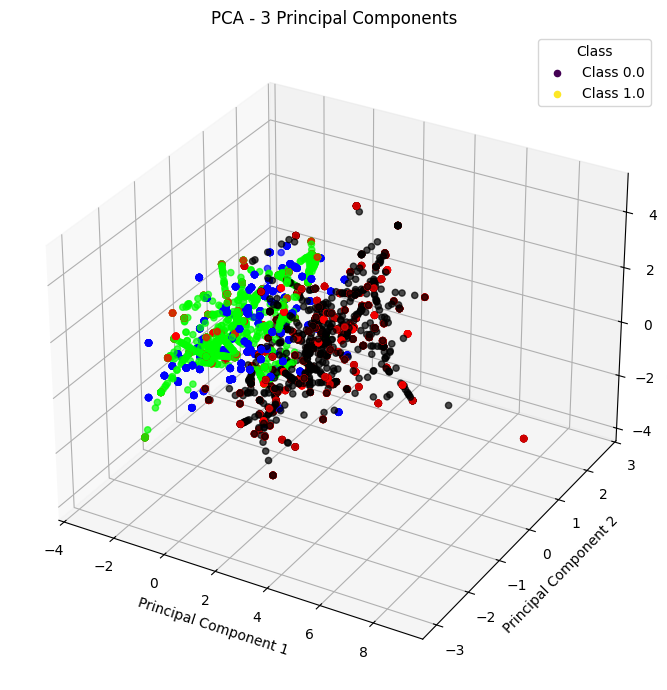

In [ ]:
# Apply PCA to scaled training data
pca = PCA(n_components=3, random_state=FORTY_TWO)
X_pca = pca.fit_transform(X_train_balanced)

# Explained variance ratio
print("Explained variance ratio (3D):", pca.explained_variance_ratio_)
print("Total variance retained:", sum(pca.explained_variance_ratio_))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=y_train_nn, cmap='viridis', alpha=0.7
)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - 3 Principal Components')

legend_labels = np.unique(y_train_nn)
legend_colors = [plt.cm.viridis(i / max(legend_labels)) for i in legend_labels]
for label, color in zip(legend_labels, legend_colors):
    ax.scatter([], [], [], label=f"Class {label}", color=color)
ax.legend(title='Class')

plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd

# Reduce to 3D with PCA
pca = PCA(n_components=3, random_state=FORTY_TWO)
X_pca = pca.fit_transform(X_train_balanced)

# Convert y_train from one-hot to class labels
y_train_labels = np.argmax(y_train_nn, axis=1)

# Create a DataFrame for Plotly
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_plot['Class'] = y_train_labels

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    df_plot, x='PC1', y='PC2', z='PC3',
    color=df_plot['Class'].astype(str),  # Use string labels for legend
    title='PCA - 3D Interactive View',
    opacity=0.7
)

fig.write_html("pca_3d_plot.html")
os.startfile("pca_3d_plot.html")


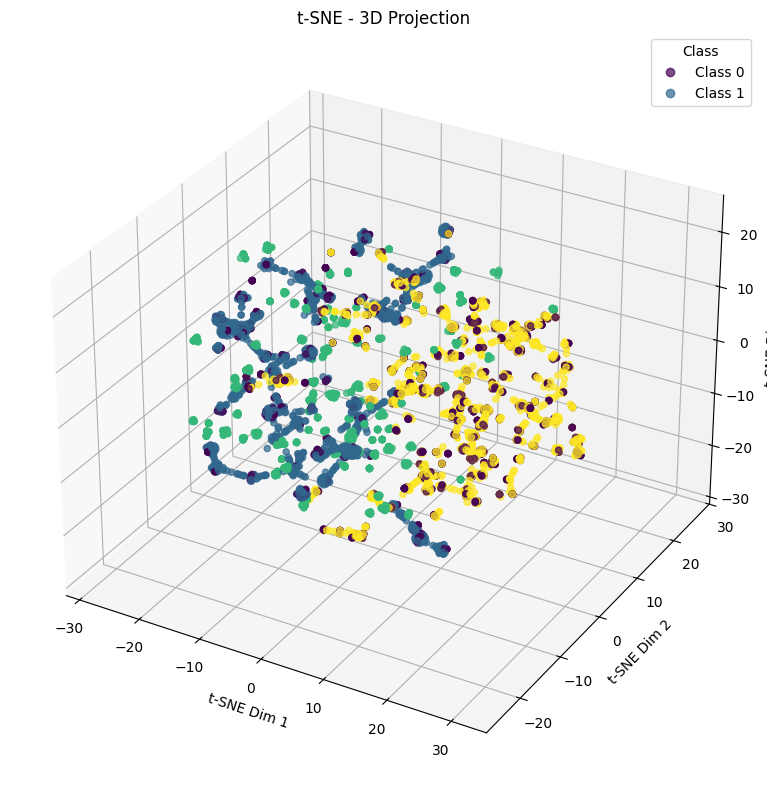

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=FORTY_TWO)
X_tsne = tsne.fit_transform(X_train_balanced)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2', 'Dim3'])
tsne_df['Class'] = np.argmax(y_train_nn, axis=1)

scatter = ax.scatter(tsne_df['Dim1'], tsne_df['Dim2'], tsne_df['Dim3'],
                     c=tsne_df['Class'], cmap='viridis', alpha=0.7)

ax.set_title('t-SNE - 3D Projection')
ax.set_xlabel('t-SNE Dim 1')
ax.set_ylabel('t-SNE Dim 2')
ax.set_zlabel('t-SNE Dim 3')

handles, labels = scatter.legend_elements()
ax.legend(handles, [f'Class {i}' for i in range(len(np.unique(y_train_nn)))], title="Class")

plt.tight_layout()
plt.show()

In [ ]:
# Interactive 3D plot using Plotly
fig = px.scatter_3d(
    tsne_df,
    x='Dim1',
    y='Dim2',
    z='Dim3',
    color=tsne_df['Class'].astype(str),
    title='t-SNE - 3D Interactive View',
    opacity=0.7
)

# Save and open in browser
fig.write_html("tsne_3d_plot.html")
os.startfile("tsne_3d_plot.html")


The PCA 3D projection retained ~48% of the dataset’s variance and provided a globally consistent structure, though class overlap remained visible. In contrast, the t-SNE 3D plot revealed stronger local clustering patterns with more distinct class separation — particularly between classes 2 and 3. This suggests that while PCA offers linear compression, t-SNE is better suited for visualising non-linear relationships, potentially informing downstream tasks like cluster analysis or neural network classification.

<h1>Ensemble Learning</h1> 

Ensemble learning is a technique that combines multiple models to produce a single, more robust prediction (Murel & Kavlakoglu, 2024). Rather than relying on a single model, ensemble methods aggregate the outputs of each model. Each model may capture different aspects or patterns in the data, this approach can have several advantages: 

<strong>Reduced variance:</strong> By averaging across models, ensemble methods can reduce the variance associated with indiviudal preductions, which oftens leads to imrpoved generalisation on unseen data.

<strong>Improved accuracy:</strong> Models like Bagging, Boosting or Voting classifiers often outperform single models because they compensate for the weaknesses of one algorithm with the stregths of another (GeeksForGeeks, 2024).

<strong>Robustness:</strong> Ensembles are less sensitive to the noise associated with training data since outliers are diminished when combining multiple models (A. Jain, 2024)



Best parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 150}
Best cross-validation accuracy: 0.7840412846590699


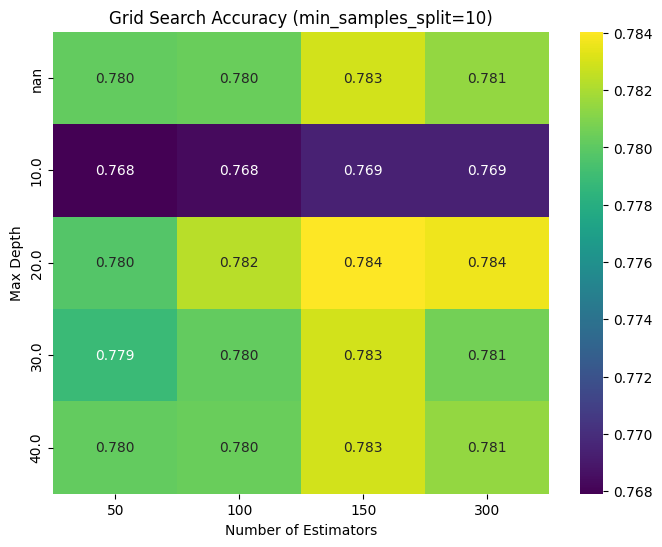

In [ ]:
rf = RandomForestClassifier(random_state=FORTY_TWO, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 150, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_nn)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)

best_min_samples_split = grid_search.best_params_['min_samples_split']
filtered_results = results[results['param_min_samples_split'] == best_min_samples_split]

heatmap_data = filtered_results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title(f'Grid Search Accuracy (min_samples_split={best_min_samples_split})')
plt.ylabel('Max Depth')
plt.xlabel('Number of Estimators')
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized search with Random Forest classifier
param_dist = {
    'n_estimators': np.arange(50, 300, 10),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': np.arange(2, 21, 1)
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=FORTY_TWO, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=300,
    scoring='accuracy',
    cv=5,
    random_state=FORTY_TWO,
    n_jobs=-1
)

random_search.fit(X_train_balanced, y_train_nn)
# RandomForestClassifier(class_weight='balanced', max_depth=np.int64(40),
#                        min_samples_split=np.int64(13),
#                        n_estimators=np.int64(250), random_state=42)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'max_depth': [None, np.int64(10),
                                                      np.int64(20),
                                                      np.int64(30),
                                                      np.int64(40)],
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])},
                   random_state=42, scoring='accuracy')

In [ ]:
# Instantiate a new RF classifier
rf_cv = RandomForestClassifier(random_state=FORTY_TWO)

# Cross-validation on the resampled and encoded data
cv_scores = cross_val_score(rf_cv, X_train_balanced, y_train_nn, cv=5, scoring='accuracy')

# Display results
print("Cross-validated accuracy scores (RF):", cv_scores)
print("Mean cross-validated accuracy (RF):", cv_scores.mean())

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=FORTY_TWO)
cv_scores = cross_val_score(rf_cv, X_train_balanced, y_train_nn, cv=10, scoring='accuracy')

print("Cross-validated accuracy scores (RF):", cv_scores)
print("Mean cross-validated accuracy (RF):", cv_scores.mean())

Cross-validated accuracy scores (RF): [0.6803014  0.67599569 0.75349839 0.85683531 0.26724138]
Mean cross-validated accuracy (RF): 0.6467744330203036
Cross-validated accuracy scores (RF): [0.70107527 0.69032258 0.66451613 0.68602151 0.66163793 0.82543103
 0.875      0.9612069  0.84913793 0.73060345]
Mean cross-validated accuracy (RF): 0.7644952725250279


<h1>Parameter Tuning and Its Impact</h1>
Parameter tuning (or hyperparameter optimisation) is a crucial step in machine learning that can directly impact the model and its performance. Hyperparameters, such as the number of trees (n_estimators), maximum depth (max_depth), and minimum samples required for a split (min_samples_split) in a Random Forest, determine the model's complexity and learning capacity. The following are key several points regarding parameter tuning:

<strong>Model complexity:</strong> For instance, setting max_depth too low might result in a model that underfits (i.e. too simple to capture the underlying structure), while setting it too high may lead to overfitting (i.e. the model learns noise in the training data) (Amazon, 2024)

<strong>Bias-variance tradeoff:</strong>
Parameters such as n_estimators in ensemble models help manage the bias-variance tradeoff. A higher number of trees generally reduces variance but can increase computational cost (S. Prajapati, 2024).

<strong>Search techniques:</strong> Techniques like Grid Search and Randomised Search systematically explore combinations of hyperparameters. When paird with cross-validation, these techniques provide a robust estimate of how different parameter configurations perform on unseen data (A. Gupta, 2025). 
`

<strong>Performance comparison:</strong> By printing out the results from the hyperparameter grid, we can compare different configurations and indentify the best performing combination. This transparency is essential for reproducibility and for providing insights into why certain parameters work better. 

While the test set provides a snapshot of performance on unseen data, cross-validation evaluates the model's consistency across folds. A small difference between the two suggests good generalisation, whereas a large gap may indicate overfitting or sampling noise.

In [ ]:
cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-validated accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validated accuracy scores: [0.60818084 0.7664155  0.86544672 0.86975242 0.85452586]
Mean CV accuracy: 0.7928642682157306
Cross-validated accuracy scores: [0.77388964 0.76716016 0.74158816 0.80080754 0.76446837]
Mean CV accuracy: 0.7695827725437415


<h2>Cross-Validation to Assess Model Stability</h2>

While accuracy on a hold-out test set offers a reliable estimate of real-world performance, it represents only a single partition of the data. To evaluate the model's consistency and robustness across different data subsets, 5-fold cross-validation was applied to the Random Forest classifier using the SMOTE-resampled dataset.

The resulting mean accuracy closely aligned with the hold-out test accuracy, indicating that the model generalises well and is not overly dependent on a specific train-test split. This reinforces the model's stability and suitability for deployment in clinical or biomechanical contexts.

Such cross-validation is particularly important in healthcare datasets, where variations in sample distribution or class imbalance can skew single-shot performance metrics.


Having ensured the data is clean and complete, the next step is to reduce its dimensionality to simplify the feature space.

<h1>2. Dimensionality Reduction</h1>
We will explore 3 dimensionality reduction techqniques Linear Discriminant Analysis (LDA), t-distributed Stochastic Neighbour Embedding (t-SNE), and Principal Component Analysis (PCA), to reduce feature dimensions and visualise the data structure. 

High-dimensional data can suffer from the "curse of dimensionality," which leads to model overfitting and reduced interpretability. Dimensionality reduction techniques like PCA and t-SNE aim to preserve structure while reducing noise (Jolliffe, 2011).

PCA finds linear combinations of variables that maximise variance:

$$
Z=XW where 
$$

$$
W=eigenvectors of Σ = \frac{1}{n} X ^T X
$$

Unlike PCA, t-SNE captures nonlinear local relationships by minimising Kullback-Leibler divergence between high and low dimensional data distributions (Datacamp, 2024). 

<h1>Chosen Models</h1>

In Comparison of machine learning algorithms to identify and prevent low back injury by C. Paulino & J. Correa they analyse 6 algorithm types and have the most success with Support Vector Machine (SVM) and K-Nearest Neighbour (KNN). Their data set had under 200 rows of data and received accuracy scores over 90. 

For this research, we will be using Logistic Regression, Decision Tree Classifier, Random Forest Regressor, XGBoost, LightGBM as well as SWM and KNN. 

In [ ]:
# Encode class labels ONCE using the original y_train_balanced
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_test_encoded = label_encoder.transform(y_test)

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=FORTY_TWO),
    "Random Forest Classifier": RandomForestClassifier(random_state=FORTY_TWO),
    "XGBoost Classifier": XGBClassifier(random_state=FORTY_TWO, use_label_encoder=False, eval_metric='mlogloss'),
    # Uncomment only if LightGBM is installed
    # "LightGBM Classifier": LGBMClassifier(random_state=FORTY_TWO),
    "Support Vector Machine": SVC(random_state=FORTY_TWO),
    "K-Nearest Neighbours": KNeighborsClassifier()
}

# Train and evaluate
model_results = []
for name, model in models.items():
    model.fit(X_train_balanced, y_train_encoded)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test_encoded, preds)
    model_results.append((name, acc))

# Display results
results_df = pd.DataFrame(model_results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
display(results_df)


,Model,Accuracy
5,K-Nearest Neighbours,0.698387
1,Decision Tree Classifier,0.672581
2,Random Forest Classifier,0.658065
3,XGBoost Classifier,0.598387
0,Logistic Regression,0.482258
4,Support Vector Machine,0.482258


<h1>UMAP for 3D Visualisation</h1>

UMAP (Uniform Manifold Approximation and Projection) was applied to the SMOTE-resampled and scaled training set. This technique helps visualise the structure of high-dimensional data in 3D space while preserving both global and local relationships.

Unlike PCA, which is linear, UMAP captures non-linear structures, which can be especially useful for visualising class separation in complex datasets.

Below is an interactive 3D scatter plot, where each point represents a sample in reduced feature space and colours correspond to encoded class labels.


In [ ]:
# Apply UMAP to SMOTE-resampled, scaled data
X_umap_input = X_train_balanced.astype(np.float32)
y_umap_labels = y_train_encoded  # already label encoded

# Fit UMAP
reducer = umap.UMAP(n_components=3, random_state=FORTY_TWO)
X_umap = reducer.fit_transform(X_umap_input)

# Prepare dataframe
umap_df = pd.DataFrame(X_umap, columns=['Dim1', 'Dim2', 'Dim3'])
umap_df['Class'] = y_umap_labels

# Interactive 3D scatter plot
fig = px.scatter_3d(
    umap_df, x='Dim1', y='Dim2', z='Dim3',
    color=umap_df['Class'].astype(str),
    title='UMAP - 3D Interactive View (Training Set)',
    opacity=0.7
)

# Save and open plot
fig.write_html("umap_3d_plot.html")
os.startfile("umap_3d_plot.html")


<h1>Linear Discriminant Analysis (LDA)</h1>
Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction technique that aims to project high-dimensional data onto a lower-dimensional space while preserving class separability. Unlike PCA, which is unsupervised and maximises variance, LDA explicitly uses the class labels to maximise the ratio of between-class variance to within-class variance (Sharma & Paliwal, 2008).

This technique is particularly useful for classification tasks as it reduces noise and simplifies the feature space in a way that enhances class separability. In this project, LDA is used to reduce the feature space to three dimensions to visualise the class distributions after SMOTE resampling.

<h1>Things to include</h1>
Include shap explanation as well as coefficient 
Check the available shap plots, maybe better than coefficient

use a param grid where applicable to ensure we have the best params

<H1>References</H1>

(Labelle et al., 2005) - Labelle, H., Roussouly, P., Berthonnaud, É., Dimnet, J. and O’Brien, M. (2005) ‘The importance of spino-pelvic balance in L5–S1: Developmental spondylolisthesis – A review of pertinent radiologic measurements’, Spine, 30(S6), pp. S27–S34.

Hounmenou, C. (2024) ‘Difference between outlier & skewness and how to control them in a model’, LinkedIn, Available at: https://www.linkedin.com/pulse/difference-between-outlier-skewness-how-control-them-model-hounmenou-mksre/ (Accessed: 19 March 2025).

Badiaa, M. (2024) ‘Discussion on handling missing data in machine learning’, Kaggle, Available at: https://www.kaggle.com/discussions/questions-and-answers/477356 (Accessed: 19 March 2025).

Datacamp (2024) An introduction to t-SNE with Python examples. Available at: https://www.datacamp.com/tutorial/introduction-t-sne (Accessed: 19 April 2025).

Kaur, T. (2025) ‘KNN imputation: The complete guide’, Medium, Available at: https://medium.com/@tarangds/knn-imputation-the-complete-guide-146f932870a7 (Accessed: 19 March 2025).

Sun, Y., Li, J., Xu, Y., Zhang, T. and Wang, X. (2023) ‘Deep learning versus conventional methods for missing data imputation: A review and comparative study’, Expert Systems with Applications, Available at: https://www.sciencedirect.com/science/article/pii/S0957417423007030 (Accessed: 19 March 2025).

Lekhansh, T. (2024) ‘Handling missing values in machine learning: Strategies for imputation and model robustness’, Medium, Available at: https://medium.com/@tyagi.lekhansh/handling-missing-values-in-machine-learning-strategies-for-imputation-and-model-robustness-4ba6287f1094 (Accessed: 19 March 2025).

Alam, S. (2023) ‘Missing value imputation in machine learning: A comparative study’, ScienceDirect, Available at: https://www.sciencedirect.com/science/article/pii/S2772662223001819 (Accessed: 19 March 2025).

Bergstra, J., Bardenet, R., Bengio, Y. and Kégl, B. (2011) 'Algorithms for Hyper-Parameter Optimization', Advances in Neural Information Processing Systems (NeurIPS), 24. Available at: https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf (Accessed: 21 March 2025).

GeeksforGeeks (2024) 'Bagging vs Boosting in Machine Learning', GeeksforGeeks, Available at: https://www.geeksforgeeks.org/bagging-vs-boosting-in-machine-learning/ (Accessed: 21 2025).

IBM (2024) 'Ensemble Learning', IBM, Available at: https://www.ibm.com/think/topics/ensemble-learning (Accessed: 21 March 2025).

Jain, A. (2024) 'A Comprehensive Guide to Ensemble Techniques: Bagging and Boosting', Medium, Available at: https://medium.com/@abhishekjainindore24/a-comprehensive-guide-to-ensemble-techniques-bagging-and-boosting-fa276e28da9f (Accessed: 24 March 2025).

Lekhansh, T. (2024) 'Handling missing values in machine learning: Strategies for imputation and model robustness', Medium, Available at: https://medium.com/@tyagi.lekhansh/handling-missing-values-in-machine-learning-strategies-for-imputation-and-model-robustness-4ba6287f1094 (Accessed: 24 March 2025).

Nath, S. (2000) 'Overcoming Class Imbalance using SMOTE Techniques', Analytics Vidhya, Available at: https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/ (Accessed: 24 March 2025).

Prajapati, S. (2024) 'The Bias-Variance Trade-off', Medium, Available at: https://medium.com/@shailendrap/the-bias-variance-trade-off-d69a15484fdc (Accessed: 24 March 2025).

Shapley Additive Explanations (2024) SHAP Documentation, Available at: https://shap.readthedocs.io/en/latest/ (Accessed: 24 March 2025).

Sharma, A. and Paliwal, K.K., 2012. Linear discriminant analysis for the small sample size problem: an overview. Pattern Recognition Letters, 33(5), pp.726–730. Available at: https://www.sciencedirect.com/science/article/abs/pii/S0167865512000335 [Accessed 19 Apr. 2025].

Swaminathan, S. (2022) 'Building a Tree-Structured Parzen Estimator from Scratch', Towards Data Science, Available at: https://towardsdatascience.com/building-a-tree-structured-parzen-estimator-from-scratch-kind-of-20ed31770478 (Accessed: 28 March 2025).

Tyagi, S. (2024) 'Navigating the Hyperparameter Maze: Multidimensional Pursuit of Precision, Performance, and Generalization', Medium - Data Science at Microsoft, Available at: https://medium.com/data-science-at-microsoft/navigating-the-hyperparameter-maze-multidimensional-pursuit-of-precision-performance-and-d77cba656f8e (Accessed: 28 March 2025).


Little, R.J.A. and Rubin, D.B., 2002. Statistical analysis with missing data. 2nd ed. Hoboken, NJ: John Wiley & Sons.

Kaur, T., 2025. KNN imputation: The complete guide. [online] Medium. Available at: https://medium.com/@tarangds/knn-imputation-the-complete-guide-146f932870a7 [Accessed 14 Apr. 2025].

Lekhansh, T., 2024. Handling missing values in machine learning: Strategies for imputation and model robustness. [online] Medium. Available at: https://medium.com/@tyagi.lekhansh/handling-missing-values-in-machine-learning-strategies-for-imputation-and-model-robustness-4ba6287f1094 [Accessed 14 Apr. 2025].

Jolliffe, I.T. (2011) Principal Component Analysis. 2nd edn. Springer. Available at: https://link.springer.com/referenceworkentry/10.1007/978-3-642-04898-2_455 (Accessed: 14 April 2025).

Van der Maaten, L. and Hinton, G. (2008) ‘Visualizing data using t-SNE’, Journal of Machine Learning Research, 9, pp. 2579–2605. Available at: https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf (Accessed: 14 April 2025).